In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from mapie.metrics import regression_coverage_score_v2
from mapie.mondrian import MondrianCP
from mapie.regression import MapieRegressor

%load_ext autoreload
%autoreload 2

In [2]:
# Create 1D regression dataset with sinusoidual function between 0 and 10 
n_points = 100000
np.random.seed(0)
X = np.linspace(0, 10, n_points).reshape(-1, 1)
group_size = n_points // 10
groups_list = []
for i in range(10):
    groups_list.append(np.array([i] * group_size))
groups = np.concatenate(groups_list)

noise_0_1 = np.random.normal(0, 0.1, group_size)
noise_1_2 = np.random.normal(0, 0.5, group_size)
noise_2_3 = np.random.normal(0, 1, group_size)
noise_3_4 = np.random.normal(0, .4, group_size)
noise_4_5 = np.random.normal(0, .2, group_size)
noise_5_6 = np.random.normal(0, .3, group_size)
noise_6_7 = np.random.normal(0, .6, group_size)
noise_7_8 = np.random.normal(0, .7, group_size)
noise_8_9 = np.random.normal(0, .8, group_size)
noise_9_10 = np.random.normal(0, .9, group_size)

y = np.concatenate(
    [
        np.sin(X[groups == 0, 0] * 2) + noise_0_1,
        np.sin(X[groups == 1, 0] * 2) + noise_1_2,
        np.sin(X[groups == 2, 0] * 2) + noise_2_3,
        np.sin(X[groups == 3, 0] * 2) + noise_3_4,
        np.sin(X[groups == 4, 0] * 2) + noise_4_5,
        np.sin(X[groups == 5, 0] * 2) + noise_5_6,
        np.sin(X[groups == 6, 0] * 2) + noise_6_7,
        np.sin(X[groups == 7, 0] * 2) + noise_7_8,
        np.sin(X[groups == 8, 0] * 2) + noise_8_9,
        np.sin(X[groups == 9, 0] * 2) + noise_9_10,
    ], axis=0
)



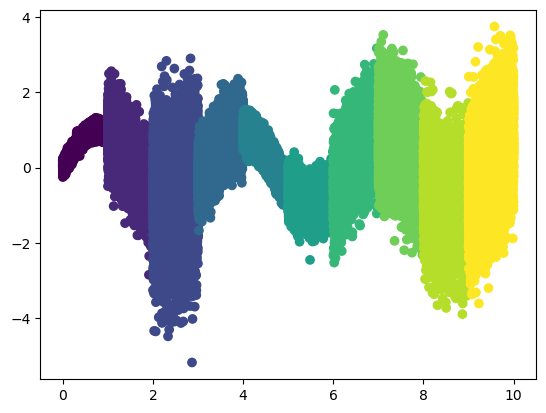

In [3]:
plt.scatter(X, y, c=groups)
plt.show()

In [4]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
groups_train_temp, groups_test, _, _ = train_test_split(groups, y, test_size=0.2, random_state=0)
X_cal, X_train, y_cal, y_train = train_test_split(X_train_temp, y_train_temp, test_size=0.5, random_state=0)
groups_cal, groups_train, _, _ = train_test_split(groups_train_temp, y_train_temp, test_size=0.5, random_state=0)

In [5]:
X_train.shape, y_train.shape, groups_train.shape

((40000, 1), (40000,), (40000,))

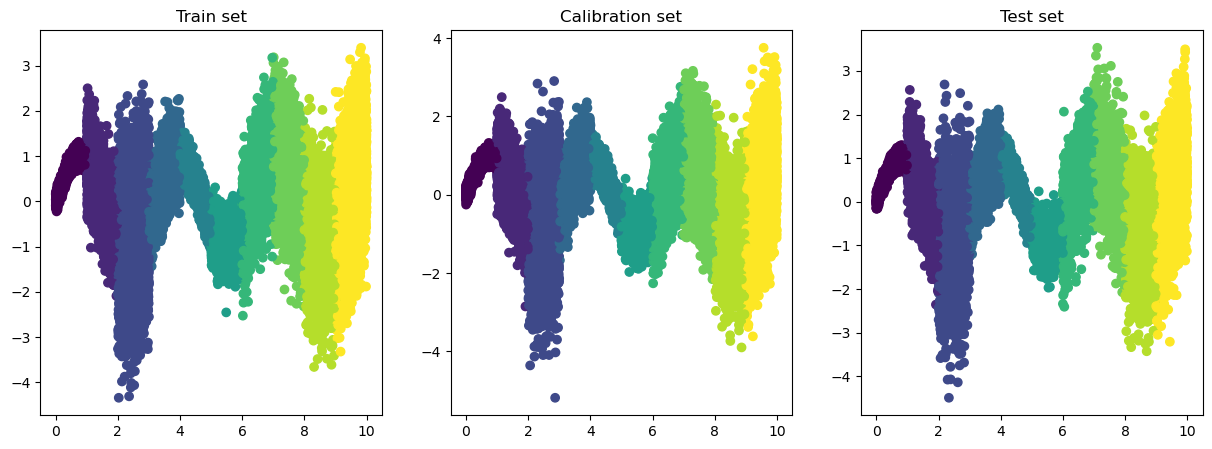

In [6]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(X_train, y_train, c=groups_train)
ax[0].set_title("Train set")
ax[1].scatter(X_cal, y_cal, c=groups_cal)
ax[1].set_title("Calibration set")
ax[2].scatter(X_test, y_test, c=groups_test)
ax[2].set_title("Test set")
plt.show()

In [7]:
print("Training set size: ", X_train.shape[0])
print("Calibration set size: ", X_cal.shape[0])
print("Test set size: ", X_test.shape[0])

Training set size:  40000
Calibration set size:  40000
Test set size:  20000


In [8]:
# Fit a random forest regressor

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)


RandomForestRegressor()

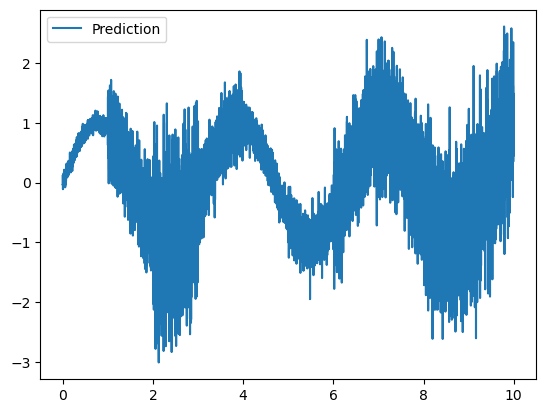

In [9]:
# Plot the prediction of the random forest regressor as a line

y_pred = rf.predict(X_test)
# plt.scatter(X_test, y_test, label="True")

#Sort the test set and the prediction to plot them as a line
sort_idx = np.argsort(X_test[:, 0])
plt.plot(X_test[sort_idx], y_pred[sort_idx], label="Prediction")

plt.legend()

In [10]:
mapie_regressor = MapieRegressor(rf, cv="prefit")
mondrian_regressor = MondrianCP(MapieRegressor(rf, cv="prefit"))

In [11]:
mapie_regressor.fit(X_cal, y_cal)
mondrian_regressor.fit(X_cal, y_cal, groups=groups_cal)

MondrianCP(mapie_estimator=MapieRegressor(cv='prefit',
                                          estimator=RandomForestRegressor()))

In [12]:
_, y_pss_split = mapie_regressor.predict(X_test, alpha=.1)
_, y_pss_mondrian = mondrian_regressor.predict(X_test, groups=groups_test, alpha=.1)

In [13]:
rf = RandomForestRegressor(
    n_estimators=100
)
rf.fit(X_train, y_train)
mondrian_regressor = MondrianCP(
    MapieRegressor(rf, cv="prefit")
)
mondrian_regressor.fit(
    X_cal, y_cal,
    groups=groups_cal
)
_, y_pss_mondrian = mondrian_regressor.predict(
    X_test, groups=groups_test, alpha=.1
)

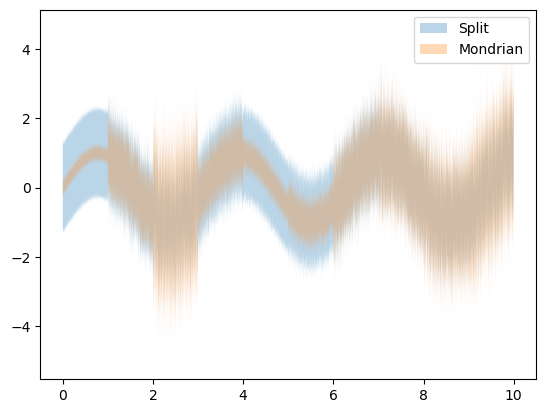

In [14]:
# Plot the prediction of the random forest regressor as a line with the prediction intervals

# plt.scatter(X_test, y_test, label="True")
sort_idx = np.argsort(X_test[:, 0])
# plt.plot(X_test[sort_idx], y_pred[sort_idx], label="Prediction")
plt.fill_between(X_test[sort_idx].flatten(), y_pss_split[sort_idx, 0].flatten(), y_pss_split[sort_idx, 1].flatten(), alpha=0.3, label="Split")
plt.fill_between(X_test[sort_idx].flatten(), y_pss_mondrian[sort_idx, 0].flatten(), y_pss_mondrian[sort_idx, 1].flatten(), alpha=0.3, label="Mondrian")
plt.legend()
plt.show()

In [15]:
# plot coverage by groups with both methods
coverages = {}
for group in np.unique(groups_test):
    coverages[group] = {}
    coverages[group]["split"] = regression_coverage_score_v2(y_test[groups_test == group], y_pss_split[groups_test == group])
    coverages[group]["mondrian"] = regression_coverage_score_v2(y_test[groups_test == group], y_pss_mondrian[groups_test == group])

/var/folders/7d/cdjx7c6d3xx42wdw5bnrmmb80000gn/T/ipykernel_90633/2054907134.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.bar(np.arange(len(coverages)) * 2, [float(coverages[group]["split"]) for group in coverages], label="Split")
/var/folders/7d/cdjx7c6d3xx42wdw5bnrmmb80000gn/T/ipykernel_90633/2054907134.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.bar(np.arange(len(coverages)) * 2 + 1, [float(coverages[group]["mondrian"]) for group in coverages], label="Mondrian")


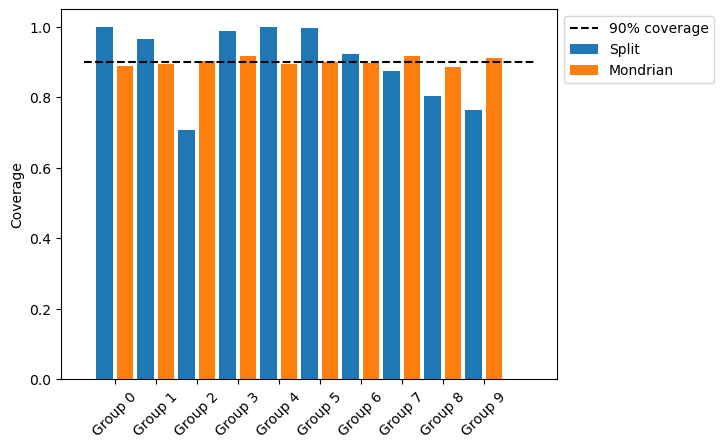

In [17]:
# Plot the coverage by groups, plot both methods side by side
plt.bar(np.arange(len(coverages)) * 2, [float(coverages[group]["split"]) for group in coverages], label="Split")
plt.bar(np.arange(len(coverages)) * 2 + 1, [float(coverages[group]["mondrian"]) for group in coverages], label="Mondrian")
plt.xticks(np.arange(len(coverages)) * 2 + .5, [f"Group {group}" for group in coverages], rotation=45)
plt.hlines(0.9, -1, 21, label="90% coverage", color="black", linestyle="--")
plt.ylabel("Coverage")

#put legend outside of the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))